# Diva data preparation and BlackBox computed without clustering

In this notebook I split the dataset in train/test/validation, then I create a random forest on Diva using the train set. I perform the clustering on the test set and using quantiles I get a set of representatives to be used in the attack. I also apply noise to the validation set.

![schema attacco](../../adult/Images/experiments.jpg)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import category_encoders as ce
import bz2
import pickle
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../../") 
import mlem
from sklearn.preprocessing import StandardScaler
from mlem.utilities import load_pickle_bz2, save_pickle_bz2, sample_from_quantile

In [2]:
OUTPUT_FOLDER = Path("./BB_DATA")
OUTPUT_FOLDER.mkdir(exist_ok=True)

Loading and pre-processing adult

In [4]:
FEATURES = ['FLG_PRES_RISCOSS',
 'IMP_V_AGG_IVA',
 'SOLVIBILITA',
 'VOL_AFF_DICH',
 'PESO_ADESIONE',
 'TIPO_DICH_ACCERT',
 'IMP_ESISTZ',
 'DETR_IVA_ACC',
 'VAL_ALIQ_MEDIA_ACQ',
 'FLG_PRES_RICORSO',
 'STATO_CONTROLLO',
 'VAL_ALIQ_M_ACQ_IMP',
 'FLG_VC',
 'IMP_V_AGG_IMPON',
 'VAR_RIMBORSO',
 'VAL_ALIQ_MEDIA_VOL',
 'IMP_IMPST_CREDIT',
 'IMP_ACQ_NOIMP',
 'COD_ATTIV_GEN',
 'IVA_OP_IMPON_DIC',
 'IMP_BEN_AMM',
 'IMP_ECC_PREC',
 'FLG_PRES_BILANCIO',
 'imp_tot_pos',
 'VAR_DETRAZIONE',
 'MAG_IMP_RIT_ACC']

In [3]:
df = pd.read_csv("./diva_clean.csv")
df

,FLG_PRES_RISCOSS,IMP_V_AGG_IVA,SOLVIBILITA,VOL_AFF_DICH,PESO_ADESIONE,TIPO_DICH_ACCERT,IMP_ESISTZ,DETR_IVA_ACC,VAL_ALIQ_MEDIA_ACQ,FLG_PRES_RICORSO,...,IMP_ACQ_NOIMP,COD_ATTIV_GEN,IVA_OP_IMPON_DIC,IMP_BEN_AMM,IMP_ECC_PREC,FLG_PRES_BILANCIO,imp_tot_pos,VAR_DETRAZIONE,MAG_IMP_RIT_ACC,Target
0,1.518260,0.230849,0.228899,0.093718,4.058525,0.477425,-0.082859,0.161744,-1.833110,-0.542534,...,0.028205,-0.761774,-0.275266,-0.025103,-0.012631,0.828543,-0.139304,0.531387,-0.035737,0
1,-0.658649,-0.008665,0.228899,-0.043983,-0.449675,-1.161895,-0.082859,-0.077551,-2.448218,-0.542534,...,-0.035253,0.158846,0.151410,-0.025933,-0.075926,-1.206937,-0.139304,-0.215376,-0.035737,0
2,-0.658649,-0.003115,0.228899,-0.044175,-0.449675,0.477425,-0.082859,-0.077551,-0.903613,-0.542534,...,-0.036188,-0.301464,0.141838,-0.026284,-0.024012,0.828543,-0.139304,-0.138035,-0.035737,0
3,-0.658649,-0.017339,1.194882,-0.050677,-0.449675,0.477425,-0.082859,-0.077551,0.473058,-0.542534,...,-0.036188,0.619156,0.181433,-0.026360,-0.075926,0.828543,-0.139304,-0.201583,-0.035737,0
4,1.518260,-0.015774,0.228899,-0.046730,-0.449675,-1.161895,-0.082859,-0.077551,-1.928793,-0.542534,...,-0.036188,0.158846,0.179735,-0.026045,-0.075926,-1.206937,-0.139304,-0.198857,-0.035737,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11824,-0.658649,-0.099681,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.030338,0.721054,-0.542534,...,-0.036188,-0.301464,-0.332388,0.009194,-0.075926,-1.206937,-0.139304,0.623064,-0.035737,1
11825,-0.658649,-0.017839,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.785494,-0.542534,...,-0.036188,1.539776,0.120378,-0.026360,-0.074398,-1.206937,-0.139304,-0.103594,-0.035737,1
11826,-0.658649,-0.037574,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.783542,-0.542534,...,-0.036188,2.000086,0.081402,-0.017289,-0.075890,0.828543,-0.139304,-0.146636,-0.035737,1
11827,-0.658649,-0.018613,0.228899,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.754251,-0.542534,...,-0.036188,2.000086,0.167016,-0.025546,-0.075926,0.828543,-0.139304,-0.178445,-0.035737,1


# Train, Test, Validation

Utility functions to add the noise to the "validation" dataset

In [5]:
from typing import Callable
from numpy import array
def frequency_based_noise(column, size):
    """
    Sample values from a column with replacement.

    Args:
        column: column to sample from
        size: number of elements to sample

    Returns:
        Array of samples
    """
    return column.sample(size, replace=True).to_numpy()


def insert_noise_categorical(dataset: pd.DataFrame, perc: float = 0.1,
                             noise_generating_function: Callable[[pd.Series, int], np.array] = frequency_based_noise):
    """
    Insert noise in a categorical dataset and returns the dataset passed as argument.

    Args:
        dataset (DataFrame): dataset on which to insert the noise ( it should only contain categorical variables )
        perc (float): percentage of noise in the range [0,1]
       noise_generating_function (Callable[[int], array]): function used to generate the noise, must take as input the number of noisy values to
                                   generate inside an argument named size and return an array containing the random values.

    Returns:
        dataset
    """
    n_rows, n_col = dataset.shape
    percentage = int(perc * n_rows)

    for c in range(n_col):
        index_to_replace = np.random.choice(dataset.index,
                                            size=percentage)
        new_values = noise_generating_function(dataset[dataset.columns[c]], size=percentage)
        assert (len(index_to_replace) == len(new_values))
        for ind, val in zip(index_to_replace, new_values):
            dataset.iloc[ind, c] = val
    return dataset


def insert_noise_numerical(dataset: pd.DataFrame, perc: float = 0.1,
                           noise_generating_function: Callable[[int], np.array] = np.random.normal):
    """
    Insert noise in a numerical dataset and returns the dataset passed as argument.

    Args:
        dataset (DataFrame): dataset on which to insert the noise.
        perc (float): percentage of noise in the range [0,1]
        noise_generating_function (Callable[[int], array]): function used to generate the noise, must take as input the number of noisy values to
                                   generate inside an argument named size and return an array containing the random values.


    Examples:

        >>> df = pd.DataFrame(data={'col1': 10 * [1], 'col2': 10 * [2], 'col3': 10 * [3]})
        >>> df[NUMERICAL] = insert_noise_numerical(df[NUMERICAL].copy(), perc=0.1, noise_generating_function=np.random.rand) # note np.random.rand has a size parameter

    """
    n_rows, n_col = dataset.shape
    percentage = int(perc * n_rows)

    for c in range(n_col):
        index_to_replace = np.random.choice(dataset.index,
                                            size=percentage)
        new_values = noise_generating_function(size=percentage)
        assert (len(index_to_replace) == len(new_values))
        for ind, val in zip(index_to_replace, new_values):
            dataset.iloc[ind, c] = val
    return dataset

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_test, validation = train_test_split(df, train_size=0.8, stratify=df['Target'], random_state=123)
train, test = train_test_split(train_test, train_size=0.7, stratify=train_test['Target'], random_state=123)

Creating a noisy version of the validation dataset

In [8]:
NUMERICAL_FEATURES = FEATURES
NUMERICAL_NOISE_PERC = 0.1

In [9]:
validation_noisy = validation.reset_index().copy()
validation_noisy[NUMERICAL_FEATURES] = insert_noise_numerical(validation_noisy[NUMERICAL_FEATURES].copy(), perc=NUMERICAL_NOISE_PERC)

In [10]:
validation_noisy = validation_noisy.drop(labels='index', axis=1)
validation_noisy

,FLG_PRES_RISCOSS,IMP_V_AGG_IVA,SOLVIBILITA,VOL_AFF_DICH,PESO_ADESIONE,TIPO_DICH_ACCERT,IMP_ESISTZ,DETR_IVA_ACC,VAL_ALIQ_MEDIA_ACQ,FLG_PRES_RICORSO,...,IMP_ACQ_NOIMP,COD_ATTIV_GEN,IVA_OP_IMPON_DIC,IMP_BEN_AMM,IMP_ECC_PREC,FLG_PRES_BILANCIO,imp_tot_pos,VAR_DETRAZIONE,MAG_IMP_RIT_ACC,Target
0,1.518260,-0.018385,0.228899,-0.049748,1.804425,0.477425,-0.082859,-0.486552,0.678094,-0.542534,...,-0.036188,-0.761774,0.181935,-0.026360,-0.075926,0.828543,0.791285,0.376661,-0.035737,0
1,1.518260,-0.033021,0.228899,-0.041191,2.274029,-1.161895,-0.082859,1.527798,-0.190868,-0.542534,...,-0.036188,-0.301464,-0.000900,-0.295780,-0.075926,-1.206937,-0.139304,-1.569730,1.150980,0
2,-0.658649,-0.018613,-0.646656,-0.050791,-0.449675,0.477425,-0.082859,-0.077551,0.754251,-0.542534,...,-0.036188,0.839885,0.167016,-0.025546,-0.075926,0.828543,-0.139304,-0.178445,-0.035737,1
3,-0.658649,-0.104643,2.160864,0.028597,-0.449675,0.477425,-0.082859,0.420650,0.777683,-0.542534,...,-0.035070,0.389001,-0.113322,0.029682,1.468611,0.828543,-0.139304,0.271478,-0.035737,1
4,1.518260,-0.012524,0.228899,-0.048758,1.804425,-1.161895,-0.082859,-0.069669,-0.103884,-0.542534,...,-0.036188,0.619156,0.174611,-0.026210,-0.075926,-1.206937,0.855653,-0.190633,-0.035737,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2361,-0.662007,-0.009548,0.228899,-0.046862,-0.449675,0.477425,-0.766649,-0.077551,0.432051,-0.542534,...,-0.036188,0.619156,0.161746,-0.020350,-0.075926,0.828543,-0.139304,-0.166723,-0.035737,0
2362,-0.658649,0.025013,1.194882,-0.027123,-0.710877,0.477425,-0.082859,-0.007056,-0.049796,1.843203,...,-0.036122,0.389001,0.007075,-0.026305,-0.075926,0.828543,0.917162,0.078250,-0.035737,1
2363,-0.658649,-0.017452,-0.737083,-0.048254,1.573909,0.477425,-0.082859,-0.060014,0.783542,-0.542534,...,-0.036188,-0.301464,0.142920,-0.026325,-0.047075,0.828543,-0.139304,-0.139772,-0.035737,0
2364,1.518260,-0.014479,0.228899,-0.049361,1.804425,-1.161895,0.559010,-0.070283,0.457437,-0.542534,...,-0.036188,2.000086,0.188145,-0.026026,-0.075926,-1.206937,-0.139304,-0.208841,-0.035737,0


In [11]:
print(f"Saving the datasets in {OUTPUT_FOLDER}")
for dataset_name in "train,test,validation,validation_noisy".split(","):
    dataset = eval(dataset_name)
    dataset.to_csv(OUTPUT_FOLDER / f"{dataset_name}.csv", index=False)

Saving the datasets in BB_DATA


# Creating the black box

In [12]:
X_train = train.drop(labels=["Target"], axis=1).to_numpy()
y_train = train.Target.to_numpy()

In [13]:
X_test = test.drop(labels=["Target"], axis=1).to_numpy()
y_test = test.Target.to_numpy()

In [14]:
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
# Hyperparameters of the grid search
__HYPERPARAMETERS = {
    "bootstrap": [True, False],
    "max_depth": [100, 350, 500],
    "min_samples_leaf": [10, 20, 50],
    "min_samples_split": [5, 10, 50],
    "n_estimators": [100, 150, 350, 500],
    "criterion": ["gini", "entropy"],
}

def create_random_forest(
        x,
        y,
        hyperparameters=__HYPERPARAMETERS,
        n_jobs=12
) -> RandomForestClassifier:
    """Creates a random forest classifier via grid search.

    Args:
        x (ndarray): Training input examples.
        y (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search.

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    rf = RandomForestClassifier()
    clf = HalvingGridSearchCV(rf, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    clf.fit(x, y)
    return clf.best_estimator_

In [16]:
rf = create_random_forest(X_train, y_train)

In [17]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2094
           1       0.85      0.77      0.81       745

    accuracy                           0.90      2839
   macro avg       0.89      0.86      0.87      2839
weighted avg       0.90      0.90      0.90      2839



In [18]:
save_pickle_bz2(OUTPUT_FOLDER / "diva_rf_noclustering.bz2", rf)

### trying AdaBoost

In [19]:
from sklearn.ensemble import AdaBoostClassifier

__HYPERPARAMETERS_AB = {
    "n_estimators": [50, 100, 150, 200],
    "random_state": [123]
}

def create_adaboost(
        x,
        y,
        hyperparameters=__HYPERPARAMETERS_AB,
        n_jobs=12
) -> RandomForestClassifier:
    """Creates a random forest classifier via grid search.

    Args:
        x (ndarray): Training input examples.
        y (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search.

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    ab = AdaBoostClassifier()
    clf = HalvingGridSearchCV(ab, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    clf.fit(x, y)
    return clf.best_estimator_


In [20]:
ab = create_adaboost(X_train, y_train)

Almost same results of random forest but way faster grid search due to less parameters

In [21]:
print(classification_report(y_test, ab.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2094
           1       0.80      0.74      0.77       745

    accuracy                           0.88      2839
   macro avg       0.86      0.84      0.85      2839
weighted avg       0.88      0.88      0.88      2839



# Clustering on the test set, computation of centroids representatives using  quantiles

Clustering utility functions

In [22]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
from kneed import KneeLocator

CLUSTERS = [*range(2, 12)]

def print_metrics(X, kmeans):
    """print the metrics of the kmeans model.
    Parameters
    ----------
        X - normalized dataset
        kmeans - model.
    Prints
    ------
        K
        SSE
        Silhouette score
        Separation
    
    """
    print(f'K={len(kmeans.cluster_centers_)}')
    print('\tSSE:\t\t{}'.format(kmeans.inertia_))
    print('\tSilhouette:\t\t{}'.format(metrics.silhouette_score(X, kmeans.labels_)))
    print('\tDaviesBouldin score:\t\t{}'.format(metrics.davies_bouldin_score(X, kmeans.labels_)))

def run_kmeans(X, range_nclusters=CLUSTERS):
    '''runs kmeans for different values of k'''
    inertia, models = [], []
    for k in range_nclusters:
        k_means = KMeans(init='k-means++', n_clusters= k, n_init=20, random_state=123)
        model = k_means.fit(X) #returns fitted estimator
        models.append(model)
        inertia.append(k_means.inertia_)
    return inertia, models

def plot_silouette(data, models):
    """
    models - list of already fit kmeans models
    """
    fig, axs = plt.subplots(ncols=len(models), figsize=(15,5), sharex=True, sharey=True)
    for i,model in enumerate(models):
        nclusters = model.n_clusters
        axs[i].set_xlim([-0.1, 1])
        axs[i].set_ylim([0, len(data) + (nclusters + 1) * 10])
        axs[i].set_title(f"$K={nclusters}$")
        
        clusters = model.predict(data)
        silhouette_avg = silhouette_score(data, clusters)
        
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(data, clusters)
        
        y_lower = 10
        for j in range(nclusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == j]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(j) / nclusters)
            axs[i].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            axs[i].text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        
        # The vertical line for average silhouette score of all the values
        axs[i].axvline(x=silhouette_avg, color="red", linestyle="--")

        axs[i].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        
    plt.tight_layout()

Clustering on numerical features

In [23]:
X_test_cluster = test.drop(labels=["Target"], axis=1)
X_cluster = X_test_cluster.to_numpy()

In [24]:
wcss, models = run_kmeans(X_cluster)

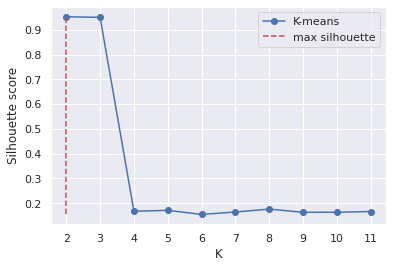

In [25]:
sil_score = []
for m in models:
    sil_score.append(silhouette_score(X_cluster, m.labels_))
    
plt.plot(CLUSTERS, sil_score, 'bo-', label="K-means")
plt.vlines(np.argmax(sil_score) + 2, min(sil_score), max(sil_score), 'r', '--', label="max silhouette")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.xticks(range(2, 12))
plt.ylabel("Silhouette score")
plt.legend()
plt.show()

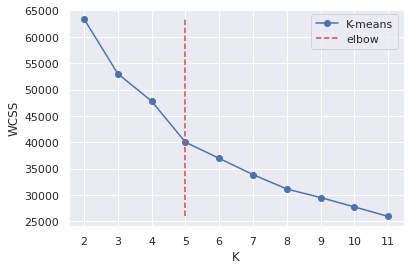

In [26]:
kl = KneeLocator(CLUSTERS, wcss, curve="convex", direction="decreasing")
plt.plot(CLUSTERS, wcss, 'o-', label="K-means")
plt.vlines(kl.elbow, min(wcss), max(wcss), 'r', '--', label="elbow")
plt.xticks(CLUSTERS)
plt.xlabel("K")
plt.ylabel("WCSS")
plt.legend()
plt.show()

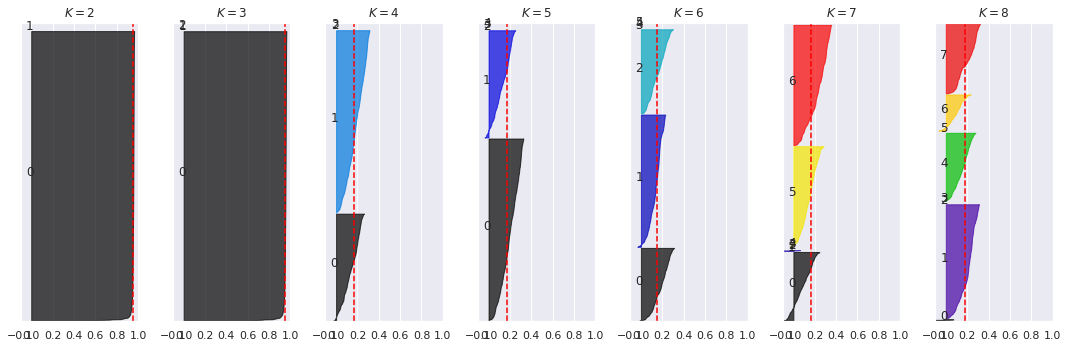

In [27]:
plot_silouette(X_cluster, models[0:7])

first pick K=$5$

In [28]:
models

[KMeans(n_clusters=2, n_init=20, random_state=123),
 KMeans(n_clusters=3, n_init=20, random_state=123),
 KMeans(n_clusters=4, n_init=20, random_state=123),
 KMeans(n_clusters=5, n_init=20, random_state=123),
 KMeans(n_clusters=6, n_init=20, random_state=123),
 KMeans(n_clusters=7, n_init=20, random_state=123),
 KMeans(n_init=20, random_state=123),
 KMeans(n_clusters=9, n_init=20, random_state=123),
 KMeans(n_clusters=10, n_init=20, random_state=123),
 KMeans(n_clusters=11, n_init=20, random_state=123)]

In [29]:
kmeans = models[3]
kmeans

KMeans(n_clusters=5, n_init=20, random_state=123)

In [30]:
test['Cluster'] = kmeans.predict(X_cluster)

In [31]:
test['Cluster'].value_counts()

0    1784
1    1052
4       1
3       1
2       1
Name: Cluster, dtype: int64

Now I drop the elements belonging to cluster 4,3,2 and keep only the first two centroids

In [32]:
test = test[test['Cluster'] != 2]
test = test[test['Cluster'] != 3]
test = test[test['Cluster'] != 4]
test.Cluster.value_counts()

0    1784
1    1052
Name: Cluster, dtype: int64

In [33]:
centroids = kmeans.cluster_centers_[:2]
np.savez(OUTPUT_FOLDER / "centroids", centroids=centroids)
train.to_csv(OUTPUT_FOLDER / "train_clustered_keep01.csv", index=False)
save_pickle_bz2(OUTPUT_FOLDER / "kmeans_k5.bz2", kmeans)

### sampling from clusters using quantiles

In [34]:
import scipy.spatial.distance as distance

def sample_from_quantile(data, centroid, nsamples=1):
    distances = distance.cdist(data[NUMERICAL_FEATURES].to_numpy(), centroid, metric="euclidean")
    df = data.copy()
    df['Distances'] = distances
    labels = ['q1', 'q2', 'q3', 'q4']
    df['Quantiles'] = pd.qcut(df.Distances, q = 4, labels=labels)
    out = pd.concat([df[df['Quantiles'].eq(label)].sample(nsamples) for label in labels])
    return out.drop(labels=['Distances', 'Quantiles'], axis=1)

Sample 1,2,3 points per quantile

In [37]:
for n_samp in (5,7,9):
    samples = []
    for label, centroid in enumerate(centroids):
        data = test[test.Cluster == label]
        samples.append(sample_from_quantile(data, np.array([centroid]), nsamples=n_samp))
    representatives = pd.concat(samples)
    representatives.to_csv(OUTPUT_FOLDER / f"clusters_representatives_quantiles_{n_samp}_{2*4*n_samp}.csv", index=False)
    x_test_clustered = representatives.drop(labels=['Target', 'Cluster'], axis=1).to_numpy()
    y_test_clustered = representatives.Target.to_numpy()
    np.savez(OUTPUT_FOLDER / f"diva_rf_noclustering_data_nsamples_{n_samp}", x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test, x_test_clustered=x_test_clustered, y_test_clustered=y_test_clustered)